In [4]:
import matplotlib.pyplot as plt
import glob
from PIL import Image, ImageDraw, ImageFont
import os
import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from collections import defaultdict

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GroupShuffleSplit

from skimage import feature
from skimage.feature import graycomatrix, graycoprops
# from skimage.feature import greycomatrix, greycoprops
from glob import glob # Used to easily find file paths
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import recall_score, roc_auc_score, roc_curve, auc


# LBP + GLCM

### First step is to loud the data

In [5]:
# Loud the data folder and the images
col_names = ['REFNUM', 'BG', 'CLASS', 'SEVERITY', 'X', 'Y', 'RADIUS']
df = pd.read_csv('data2.txt', sep="\s+", names=col_names, header=None)
df['CANCER'] = df['SEVERITY'].apply(lambda x: 1 if x in ['B', 'M'] else 0)

images_path = "all-mias"

all_images = []
all_labels = []
all_groups = []

for filename in sorted(os.listdir(images_path)):
    if filename.lower().endswith('.pgm'):
        ref_num = os.path.splitext(filename)[0]
        record = df[df['REFNUM'] == ref_num]

        if not record.empty:
            full_path = os.path.join(images_path, filename)
            img_array = cv2.imread(full_path, cv2.IMREAD_GRAYSCALE)
            
            clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
            img_eq = clahe.apply(img_array)

            labels = record['CANCER'].iloc[0]
            x, y, radius = record[['X', 'Y', 'RADIUS']].iloc[0]
            
            # Handle ROI extraction
            if labels == 1 and pd.notna(x) and pd.notna(y) and pd.notna(radius):
                # Adjust for bottom-left origin: flip Y coordinate
                x, y, radius = int(x), int(1024 - float(y)), int(radius)  # Y = 1024 - y for top-left origin
                # Crop a square ROI around (x, y) with size 2*radius
                roi = img_eq[max(0, y-radius):min(1024, y+radius), max(0, x-radius):min(1024, x+radius)]
                # Ensure ROI is not empty; resize to a fixed size (e.g., 128x128) for consistency
                if roi.size > 0:
                    roi = cv2.resize(roi, (256, 256), interpolation=cv2.INTER_AREA)
                else:
                    roi = img_eq  # Fallback to full image if ROI is invalid
            else:
                # For normal images or missing coordinates, use the entire image resized
                roi = cv2.resize(img_eq, (256, 256), interpolation=cv2.INTER_AREA)
            
            all_images.append(roi)
            all_labels.append(labels)
            all_groups.append(ref_num[:-1])

print("Data has been louded successfully")
# plt.imshow(img_eq, cmap='gray')
## Print out the table from dataset
print(f"Image list {len(all_images)}")
print(f"Labels list {len(all_labels)}")
df.head(5)
# full details of the table

Data has been louded successfully
Image list 324
Labels list 324


,REFNUM,BG,CLASS,SEVERITY,X,Y,RADIUS,CANCER
0,REFNUM,BG,CLASS,SEVERITY,X,Y,RADIUS,0
1,mdb001,G,CIRC,B,535,425,197,1
2,mdb002,G,CIRC,B,522,280,69,1
3,mdb003,D,NORM,NaN,NaN,NaN,NaN,0
4,mdb004,D,NORM,NaN,NaN,NaN,NaN,0


# GLCM

#### 2 - applyed the Gray-Level Co-occurrence Matrix (GLCM)


In [6]:
def extract_glcm_features(patch, 
                          distances=[1, 3, 5], 
                          angles=[0, np.pi/4, np.pi/2, 3*np.pi/4], 
                          levels=256):
    """
    Compute GLCM and summary stats for a single gray‑scale patch (2D ndarray).
    Returns a dict: e.g. {'contrast_mean':…, 'contrast_var':…, 'homogeneity_mean':…, …}
    """
    patch = (patch * (levels - 1)).astype(np.uint8) if patch.max() <= 1 else patch.astype(np.uint8)
    
    glcm = graycomatrix(patch,
                        distances=distances,
                        angles=angles,
                        levels=levels,
                        symmetric=True,
                        normed=True)

    props = ['contrast', 'dissimilarity', 'homogeneity', 'ASM', 'energy', 'correlation']
    feats = {}
    for prop in props:
        mat = graycoprops(glcm, prop)  # shape = (len(distances), len(angles))
        feats[f'{prop}_mean'] = mat.mean()
        feats[f'{prop}_var']  = mat.var()
    return feats

# LBP
#### 3 - Applying the Local Binaryt Pattern (LPB)

In [7]:
normalaized_img = [] # holding the LBP maps
    
for img in all_images:
    # Normalazing the image 
    if img.max() > img.min():
        n_img = ((img - img.min()) / (img.max() - img.min()) * 255) 
    else:
        n_img = img
    # normalaized_img.append(n_img)
    P = 8
    R = 3
    method = 'uniform'
    LBP = feature.local_binary_pattern(n_img, P, R, method)
#   bins_num = int(n_img.max()) + 1
    normalaized_img.append(LBP)
print(len(normalaized_img))
# print(normalaized_img.shape)

print("Computing the image and histogram for pooling and classification...")

def compute_histograms_for_each_region(normalaized_img, G=6, n_bins=59):
    #compute th histogram from 255 in image size to 59 =>  reduce the number of bins
    histogram = []

    """
    # Pooling the image in to 6 x 6
    H = 1020 # height
    W = 1020 # width
    #G = 6 # Number of Grid 6 * 6 
    hor = int(H / G) # height of each region
    wor = int(W / G) # width of each region
    """
    H, W = normalaized_img.shape
    hor, wor = H // G, W // G
# Pooling the data into 6 * 6 regions   
    for i in range(G):
        for j in range(G):
            row_start = i * hor
            row_end = (i + 1) * hor
            col_start = j * wor
            col_end = (i + 1) * wor
            region = normalaized_img[row_start:row_end, col_start:col_end]

            hist, _ = np.histogram(region.ravel(), bins=n_bins, range=(0, n_bins))
            hist = hist.astype(float)
            if hist.sum() > 0:    
                hist /= hist.sum()
        
            histogram.append(hist)

    # print(len(histogram))
    # count = 0
    # for i in range(count):
    #     count + 1
    #     print(f"Histogram Done!. . . {i}")
    return histogram


# histogram = compute_histograms_for_each_region(normalaized_img)
# print(len(histogram))

C:\Users\aa23147\AppData\Roaming\Python\Python310\site-packages\skimage\feature\texture.py:385: UserWarning: Applying `local_binary_pattern` to floating-point images may give unexpected results when small numerical differences between adjacent pixels are present. It is recommended to use this function with images of integer dtype.
  warnings.warn(


324
Computing the image and histogram for pooling and classification...


In [8]:
# Loop over your ROIs, build a DataFrame of features + labels + group IDs base on GLCM function
records = [] # records the data
for roi, label, grp in zip(all_images, all_labels, all_groups):
    glcm_feats = extract_glcm_features(roi)
    # lbp_feats  = compute_histograms_for_each_region(roi) # ?????????????
    glcm_feats['label'] = label
    glcm_feats['group'] = grp       
    records.append(glcm_feats)

    
df = pd.DataFrame.from_records(records) # sort the recorded data into the dataframe
print("GLCM feature matrix:", df.shape)
print(df.head())

# 3) Prepare for data training 
X = df.drop(columns=['label','group']).values
y = df['label'].values  

X_glcm = X

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

##############################
##############################

x_list = []
y_list = []
for lbp_img, label in zip(normalaized_img, all_labels): # ??//??????????????
    histogram = compute_histograms_for_each_region(lbp_img)

    f_vector = np.concatenate(histogram)
    f_vector /= np.linalg.norm(f_vector) + 1e-10

    x_list.append(f_vector)
    y_list.append(label)

X = np.array(x_list)
y = np.array(y_list)
X_lbp = X
print("Function has been done successfully")

GLCM feature matrix: (324, 14)
   contrast_mean   contrast_var  dissimilarity_mean  dissimilarity_var  \
0     117.391427    7297.511236            7.270573           9.409434   
1      19.812110     186.927860            3.125081           1.573940   
2     365.555063   78600.626153            6.565108           9.672931   
3     460.872543  129591.976105            7.249875          12.577701   
4      39.197109     858.594241            4.168859           3.119797   

   homogeneity_mean  homogeneity_var  ASM_mean       ASM_var  energy_mean  \
0          0.184442         0.005042  0.000339  1.429746e-08     0.018130   
1          0.322144         0.014375  0.001044  2.321923e-07     0.031542   
2          0.569111         0.001664  0.176609  1.137524e-04     0.420054   
3          0.540402         0.001760  0.156318  8.633963e-05     0.395193   
4          0.279597         0.014106  0.000733  1.493392e-07     0.026271   

   energy_var  correlation_mean  correlation_var  label  grou

In [9]:
print("GLCM samples:", X_glcm.shape[0])
print("LBP samples :", X_lbp.shape[0])
print("Label count:", y.shape[0])

GLCM samples: 324
LBP samples : 324
Label count: 324


In [10]:
print("GLCM labels:", df['label'].values[:5])
print("LBP labels:", y_list[:5])

assert X_glcm.shape[0] == X_lbp.shape[0] == y.shape[0], "Mismatch in sample counts!"
X_combined = np.hstack([X_glcm, X_lbp])
print("Fused feature shape : ", X_combined.shape)

scaler = StandardScaler()
X_ready = scaler.fit_transform(X_combined)
clf = RandomForestClassifier(n_estimators=200, random_state=42)

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scores = cross_val_score(clf, X_ready, y, cv=cv, scoring='roc_auc')
print("ROC‑AUC:", scores.mean(), "±", scores.std())

GLCM labels: [1 1 0 0 1]
LBP labels: [1, 1, 0, 0, 1]
Fused feature shape :  (324, 2136)
ROC‑AUC: 0.9854984093319195 ± 0.019039728533377997


In [12]:
from sklearn.model_selection import StratifiedKFold, cross_validate
from sklearn.model_selection import GroupKFold

scoring = ['accuracy', 'precision', 'recall', 'f1', 'roc_auc']

# cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv = GroupKFold(n_splits=5)
scores = cross_val_score(
    clf,
    X_ready,
    y,
    cv=cv.split(X_ready, y, all_groups),
    scoring='roc_auc'
)
print(f"Group‑CV ROC‑AUC: {scores.mean():.3f} ± {scores.std():.3f}")

cv_results = cross_validate(
    clf, X_ready, y,
    cv=cv,
     groups = all_groups,
    scoring=scoring,
    return_train_score=False
)

for metric in scoring:
    scores = cv_results[f'test_{metric}']
    print(f"{metric.capitalize():<8} : {scores.mean():.3f} ± {scores.std():.3f}")
unique_codes = np.unique(LBP)
print(" ")
print("Unique LBP codes in this image:", unique_codes)

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,    # for reproducibility
    stratify=y          # preserves class ratios
)

rf_model = RandomForestClassifier(
    n_estimators=250,
    class_weight = 'balanced',
    max_depth=None,
    min_samples_split=10,
    random_state=65,
    n_jobs=-1
)
rf_model.fit(X_train, y_train)

# 5. Predict
y_pred = rf_model.predict(X_test)
y_prob = rf_model.predict_proba(X_test)  # if you need probabilities

from sklearn.metrics import classification_report, confusion_matrix
print(classification_report(y_test, y_pred))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

Group‑CV ROC‑AUC: 0.984 ± 0.010
Accuracy : 0.985 ± 0.009
Precision : 1.000 ± 0.000
Recall   : 0.956 ± 0.024
F1       : 0.977 ± 0.012
Roc_auc  : 0.984 ± 0.010
 
Unique LBP codes in this image: [0. 1. 2. 3. 4. 5. 6. 7. 8. 9.]
              precision    recall  f1-score   support

           0       0.98      1.00      0.99        42
           1       1.00      0.96      0.98        23

    accuracy                           0.98        65
   macro avg       0.99      0.98      0.98        65
weighted avg       0.98      0.98      0.98        65

Confusion Matrix:
[[42  0]
 [ 1 22]]


Train score: 1.000
Test  score: 0.985
##############
[[42  0]
 [ 1 22]]
              precision    recall  f1-score   support

           0       0.98      1.00      0.99        42
           1       1.00      0.96      0.98        23

    accuracy                           0.98        65
   macro avg       0.99      0.98      0.98        65
weighted avg       0.98      0.98      0.98        65

#############
Cross-validated accuracy: 0.9815384615384616 ± 0.017941390445677833
#############


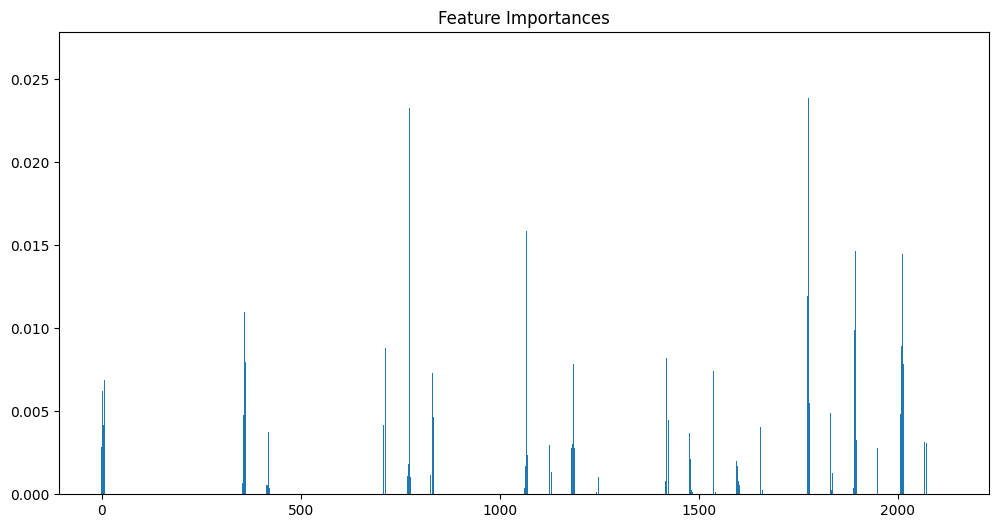

In [16]:
clf = RandomForestClassifier(n_estimators=200, random_state=42)

# Step 2 — Train (fit) the classifier
clf.fit(X_train, y_train)

# Step 3 — Now it's safe to evaluate it
train_score = clf.score(X_train, y_train)
test_score  = clf.score(X_test, y_test)

print(f"Train score: {train_score:.3f}")
print(f"Test  score: {test_score:.3f}")
print("##############")
from sklearn.metrics import confusion_matrix, classification_report
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))
print("#############")
from sklearn.model_selection import StratifiedKFold, cross_val_score

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scores = cross_val_score(rf_model, X, y, cv=cv, scoring='accuracy')
print("Cross-validated accuracy:", scores.mean(), "±", scores.std())
print("#############")

import matplotlib.pyplot as plt

importances = rf_model.feature_importances_
plt.figure(figsize=(12,6))
plt.bar(range(len(importances)), importances)
plt.title("Feature Importances")
plt.show()